# Predict survival on the Titanic

## feature engineering with missing values

In [2]:
import pandas as pd
import numpy as np

In [7]:
total = pd.read_csv("../data/total_V2.csv",index_col=0)

In [13]:
total.shape

(1309, 18)

In [14]:
total.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family,Title,ticket_words,ticket_number,cabin_word,cabin_number
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,Mr,A/5,21171,NaN,NaN
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,Mrs,PC,17599,C,85.0


In [9]:
# check how many missing value for each varible
total.apply(lambda x: sum(pd.isnull(x)))

Age               263
Cabin            1014
Embarked            2
Fare                1
Name                0
Parch               0
PassengerId         0
Pclass              0
Sex                 0
SibSp               0
Survived          418
Ticket              0
Family              0
Title               0
ticket_words        0
ticket_number       0
cabin_word       1014
cabin_number     1020
dtype: int64

### fillin embarked and fare with mode value 

In [10]:
total = total.fillna({'Embarked':'S','Fare':np.mean(total.Fare)})

### build a random forest model deal with the missing age data 

In [119]:
test = total[pd.isnull(total.Age) == False]

In [147]:
## take bins with age varible 
def take_bins(x,bins=5):
    bins = np.linspace(x.min(), x.max(), bins)
    print bins
    return np.digitize(x, bins)

In [120]:
test["Age"] = take_bins(test.Age,bins=6)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
varibles = ['Title','Family','Parch','Fare','Pclass']  # varibles may affect age

test[varibles][:5]

,Title,Family,Parch,Fare,Pclass
0,Mr,1,0,7.2500,3
1,Mrs,1,0,71.2833,1
2,Miss,0,0,7.9250,3
3,Mrs,1,0,53.1000,1
4,Mr,0,0,8.0500,3


In [123]:
from sklearn.preprocessing import LabelEncoder  

lb = LabelEncoder()
test.Title = lb.fit_transform(test.Title)

In [124]:
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(test[varibles], test.Age, test_size=0.2)

In [125]:
len(x_train),len(x_test)

(836, 210)

In [138]:
from sklearn.svm import SVC
clf = SVC(C=1000, tol= 0.01, decision_function_shape='ovo', probability= True, gamma= 0.001)
clf.fit(x_train,y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.01, verbose=False)

In [139]:
accuracy_score(clf.predict(x_test),y_test)

0.60476190476190472

In [197]:
# prepare for prediction
train = total[varibles]
train.Title = lb.fit_transform(train.Title)
train[:5]

,Title,Family,Parch,Fare,Pclass
0,2,1,0,7.2500,3
1,3,1,0,71.2833,1
2,1,0,0,7.9250,3
3,3,1,0,53.1000,1
4,2,0,0,8.0500,3


In [198]:
train.reset_index(drop=True,inplace=True)
total.reset_index(drop=True,inplace=True)

In [201]:
tmp = take_bins(total.Age,bins=6)
res = []
for i in range(len(total.Age)):
    if pd.isnull(total.Age[i]):
        res.append(clf.predict([train.loc[i,:]])[0])
    else:
        res.append(tmp[i])

[  0.17   16.136  32.102  48.068  64.034  80.   ]


In [202]:
total['Age_pred'] = res

[  0.17   16.136  32.102  48.068  64.034  80.   ]


(array([ 151.,    0.,  720.,    0.,  318.,    0.,  107.,    0.,   12.,    1.]),
 array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ]),
 <a list of 10 Patch objects>)

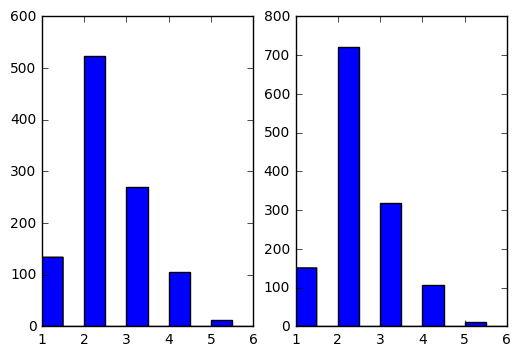

In [220]:
f1,f2 = plt.subplot(121),plt.subplot(122)  
f1.hist(take_bins(total.Age[pd.notnull(total.Age)],6))
f2.hist(total['Age_pred'])

### generate new varible using ticket_words, ticket_number, cabin_word and carbin_number to indicate location similarity, using mean of survival to represent the survival prob

In [225]:
tmp = total.pivot_table(columns = "Pclass", index='ticket_words', values='PassengerId',
                  aggfunc='count')
tmp.head()

Pclass,1,2,3
ticket_words,,,
A./5.,NaN,NaN,3.0
A.2.,NaN,NaN,1.0
A.5.,NaN,NaN,3.0
A/4,NaN,NaN,6.0
A/4.,NaN,NaN,3.0


In [226]:
simi_mask = tmp.apply(lambda x: min(pd.isnull(x) == np.bool_([1,1,0]))==1,1) 
ticket_words_3class = tmp[simi_mask].index.tolist()
simi_mask = tmp.apply(lambda x: min(pd.isnull(x) == np.bool_([1,0,1]))==1,1) 
ticket_words_2class = tmp[simi_mask].index.tolist()
simi_mask = tmp.apply(lambda x: min(pd.isnull(x) == np.bool_([0,1,1]))==1,1) 
ticket_words_1class = tmp[simi_mask].index.tolist()

In [227]:
transform = []
for item in total.ticket_words:
    if item in ticket_words_3class:
        transform.append("ticket_words_3class")
    elif item in ticket_words_2class:
        transform.append("ticket_words_2class")
    elif item in ticket_words_1class:
        transform.append("ticket_words_1class")
    else:
        transform.append(item)
total['ticket_words_trans'] = transform

In [228]:
total.columns

Index([u'Age', u'Cabin', u'Embarked', u'Fare', u'Name', u'Parch',
       u'PassengerId', u'Pclass', u'Sex', u'SibSp', u'Survived', u'Ticket',
       u'Family', u'Title', u'ticket_words', u'ticket_number', u'cabin_word',
       u'cabin_number', u'Age_pred', u'ticket_words_trans'],
      dtype='object')

In [234]:
varibles = ['ticket_words_trans','ticket_number','cabin_word','cabin_number']
test = total[varibles]
test.fillna(0,inplace=True)
test[:5]

,ticket_words_trans,ticket_number,cabin_word,cabin_number
0,ticket_words_3class,21171,0,0.0
1,ticket_words_1class,17599,C,85.0
2,ticket_words_3class,3101282,0,0.0
3,noword,113803,C,123.0
4,noword,373450,0,0.0


In [235]:
test.ticket_words_trans = lb.fit_transform(test.ticket_words_trans)
test.cabin_word = lb.fit_transform(test.cabin_word)

In [266]:
from sklearn.neighbors import NearestNeighbors
mse = {}
for test_neighbors in range(3,21):
    nbrs = NearestNeighbors(n_neighbors=test_neighbors, algorithm='ball_tree').fit(test)
    neighbors = nbrs.kneighbors(return_distance=False)
    location_survival_rate = [np.nanmean(total.ix[x,'Survived']) for x in neighbors]
    location_survival_rate = np.where(pd.isnull(location_survival_rate),
                                      np.nanmean(location_survival_rate),location_survival_rate)
    tmp = np.nansum([x ** 2 for x in (total.Survived - location_survival_rate)])
    mse[test_neighbors] = tmp
mse

{3: 244.83108559716322,
 4: 227.89214205916542,
 5: 222.51744949295386,
 6: 212.59041941527789,
 7: 210.6206203053915,
 8: 209.63455924036282,
 9: 203.13092482363317,
 10: 198.45465057319228,
 11: 195.80219385802991,
 12: 196.05558488799562,
 13: 197.04652228655124,
 14: 197.45169390915291,
 15: 196.30122977324382,
 16: 195.9914258729163,
 17: 195.2165068528565,
 18: 192.35359917170038,
 19: 192.59900381739601,
 20: 193.88678531689442}

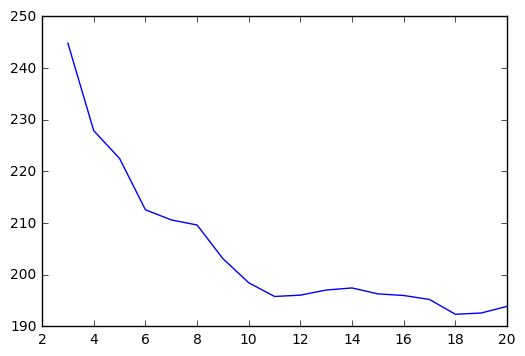

In [271]:
plt.plot(mse.keys(),mse.values())

In [272]:
## using test_neighbors == 11 as final prediction
nbrs = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(test)
neighbors = nbrs.kneighbors(return_distance=False)
## using mean of survival chance as result
location_survival_rate = [np.nanmean(total.ix[x,'Survived']) for x in neighbors]
## replace nan value with mean of all people's survival chance
location_survival_rate = np.where(pd.isnull(location_survival_rate),
                                  np.nanmean(location_survival_rate),location_survival_rate)

In [273]:
total['location_survival_rate'] = location_survival_rate

In [275]:
total.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket,Family,Title,ticket_words,ticket_number,cabin_word,cabin_number,Age_pred,ticket_words_trans,location_survival_rate
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,A/5 21171,1,Mr,A/5,21171,NaN,NaN,2,ticket_words_3class,0.285714
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,PC 17599,1,Mrs,PC,17599,C,85.0,3,ticket_words_1class,0.500000
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,STON/O2. 3101282,0,Miss,STON/O2.,3101282,NaN,NaN,2,ticket_words_3class,0.600000
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,113803,1,Mrs,noword,113803,C,123.0,3,noword,0.750000
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,373450,0,Mr,noword,373450,NaN,NaN,3,noword,0.111111


In [274]:
## write file 
total.to_csv("../data/total_V3.csv")